We begin by first importing the historical data for the S&P 400 MidCap 400 Index:

In [2]:
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, kstest, jarque_bera
from datetime import datetime, timedelta


In [3]:
#S&P MidCap 400 Index
ticker = "^MID"

#Closing prices for a period of 2 years
end_date = datetime.strptime("05/04/2024", "%d/%m/%Y")
start_date = end_date - timedelta(days=3*365)

data_midcap = yf.download(ticker, start=start_date, end= end_date)
data_midcap=data_midcap[['Close']]
data_midcap

#Computes log returns
data_midcap['LogReturns'] = np.log(data_midcap['Close'] / data_midcap['Close'].shift(1))
data_midcap.dropna(inplace=True)
data_midcap

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,LogReturns
Ticker,^MID,
Date,,
2021-04-07,2647.919922,-0.007052
2021-04-08,2657.889893,0.003758
2021-04-09,2670.520020,0.004741
2021-04-12,2679.310059,0.003286
2021-04-13,2667.580078,-0.004388
...,...,...
2024-03-28,3046.360107,0.003954
2024-04-01,3024.810059,-0.007099


Examining the Distribution of Observed Returns

Descriptive Statistics (S&P MidCap 400 - Last 4 Years):
  Daily Mean (μ): 0.0001
  Daily Std Dev (σ): 0.0127
  Annualized Mean (μ): 0.0354
  Annualized Std Dev (σ): 0.2013


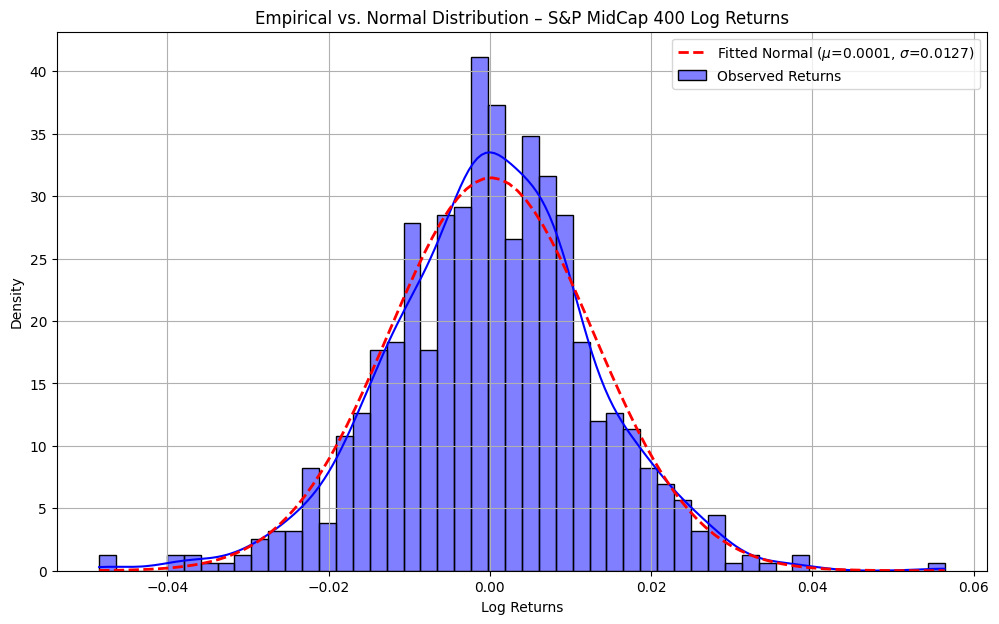


Empirical Distribution Moments:
  Skewness: -0.0645
  Kurtosis: 0.9448

Normal Distribution Moments:
  Mean: 0.0001
  Std Dev: 0.0127
  Skewness: 0 
  Kurtosis: 0

Kolmogorov–Smirnov Test Result:
  Statistic: 0.0373
  p-value: 0.2391
  Fail to reject H0: Empirical distribution ~ Normal


In [4]:
# Descriptive statistics:
H_returns = data_midcap['LogReturns']
H_mean = H_returns.mean()
H_sigma = H_returns.std()

trading_days = 252
annual_mean = H_mean * trading_days
annual_sigma = H_sigma * np.sqrt(trading_days)

print("Descriptive Statistics (S&P MidCap 400 - Last 4 Years):")
print(f"  Daily Mean (μ): {H_mean:.4f}")
print(f"  Daily Std Dev (σ): {H_sigma:.4f}")
print(f"  Annualized Mean (μ): {annual_mean:.4f}")
print(f"  Annualized Std Dev (σ): {annual_sigma:.4f}")

# Fitting a Normal Distribution
adjusted_normal_distribution = norm(loc= H_mean, scale= H_sigma)
x = np.linspace(H_returns.min(), H_returns.max(), 100)
pdf = adjusted_normal_distribution.pdf(x)

# Observed Returns + Normal PDF Plot
plt.figure(figsize=(12, 7))
sns.histplot(H_returns, bins=50, kde=True, stat="density", color='blue', label='Observed Returns')
plt.plot(x, pdf, 'r--', linewidth=2, label=f'Fitted Normal ($\mu$={H_mean:.4f}, $\sigma$={H_sigma:.4f})')
plt.title('Empirical vs. Normal Distribution – S&P MidCap 400 Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Testing for normality
print("\nEmpirical Distribution Moments:")
print(f"  Skewness: {H_returns.skew():.4f}")
print(f"  Kurtosis: {H_returns.kurtosis():.4f}")

print("\nNormal Distribution Moments:")
print(f"  Mean: {adjusted_normal_distribution.mean():.4f}")
print(f"  Std Dev: {adjusted_normal_distribution.std():.4f}")
print(f"  Skewness: 0 ")
print(f"  Kurtosis: 0")

# Kolmogorov-Smirnov test for Normality
kstest_result = kstest(H_returns, 'norm', args=(H_mean, H_sigma))
print(f"\nKolmogorov–Smirnov Test Result:")
print(f"  Statistic: {kstest_result.statistic:.4f}")
print(f"  p-value: {kstest_result.pvalue:.4f}")
if kstest_result.pvalue < 0.05:
    print("  Reject H0: Empirical distribution is not Normal")
else:
    print("  Fail to reject H0: Empirical distribution ~ Normal")



Simulating Paths of a GBM by Using MC simulation to model the evolution of the price of the index

<ipython-input-5-593a26788ff5>:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


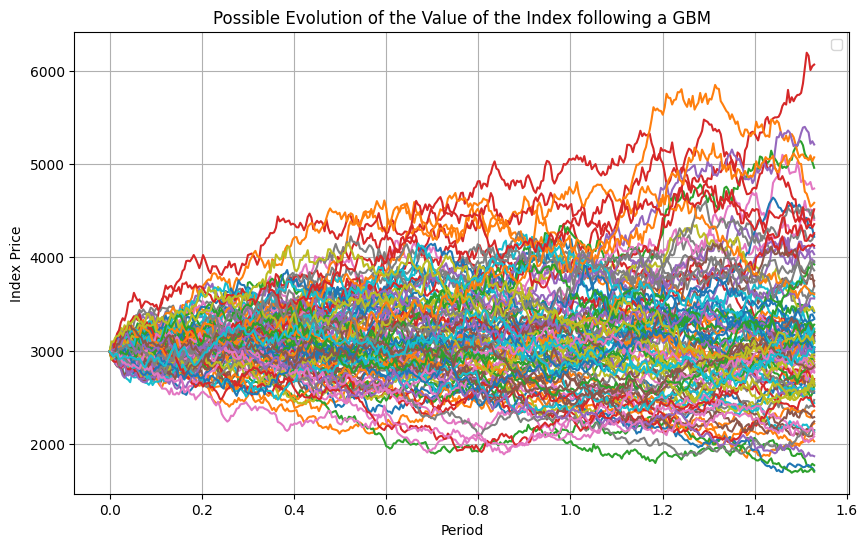

Average Index price: 3154.82
Standard deviation of Index prices: 793.26


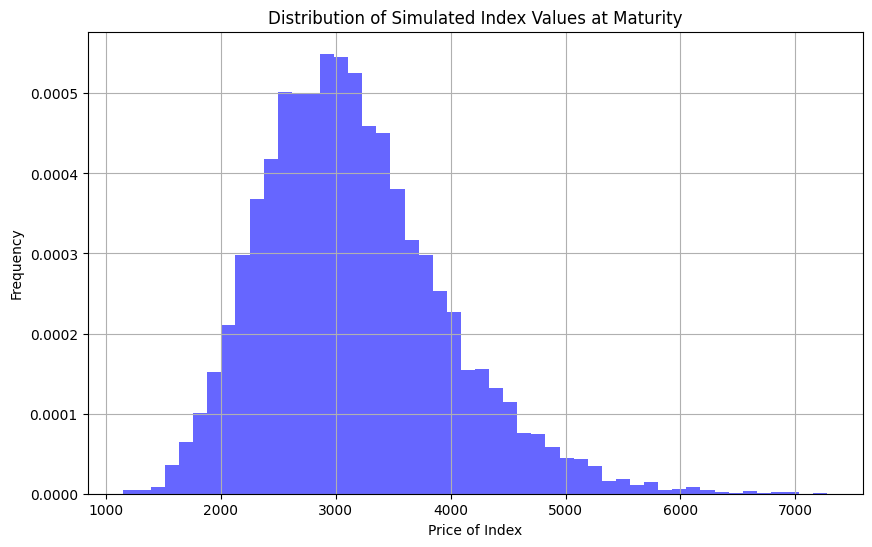

In [5]:
def gbm_simulations(n_simulations, n_steps, dt, mu, sigma, S0):
    """
    Function simulating multiple paths of a GBM by using MC simulation

    """
     # Sets the initial Index price for all paths
    simulations = np.zeros((n_simulations, n_steps))
    simulations[:, 0] = S0

    increments = np.random.normal((mu - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), (n_simulations, n_steps - 1))

    # Compute the paths
    for i in range(1, n_steps):
        simulations[:, i] = simulations[:, i-1] * np.exp(increments[:, i-1])
    return simulations

# Defining Key Parameters for the simulation
T = 1.5288 #Or 1.5 (Time to maturity)
r = 0.045 # Risk-free rate (Annualized) 10 year T-note
S0 = 2989.16  # Initial price
N = 0.33454  # Number of underlyings defined in certificate
K_1 = 3422.5882 # Strike of the Short Put

n_simulations = 10000  # Number of paths
n_steps = 378  # Number of trading days in the period
mu = 0.0354  # Drift coefficient
sigma = 0.2013  # Volatility coefficient
dt = T/n_steps

# Simulate the paths
simulations = gbm_simulations(n_simulations, n_steps, dt, mu, sigma, S0)

# Time array for plotting
time = np.linspace(0, T, n_steps)

# Takes a subpart of the simulations for a better visulaization of the different paths
plt.figure(figsize=(10, 6))
for i in range(min(100, n_simulations)):
    plt.plot(time,simulations[i])

plt.title('Possible Evolution of the Value of the Index following a GBM')
plt.xlabel('Period')
plt.ylabel('Index Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate mean and standard deviation of the last price of the Index for each possible trajectory
end_price = simulations[:, -1]
m_end_price = np.mean(end_price)
std_end_price = np.std(end_price)

print(f"Average Index price: {m_end_price:.2f}")
print(f"Standard deviation of Index prices: {std_end_price:.2f}")

# Plot the histogram of last value of the Index prices for eahc possible trajectors
plt.figure(figsize=(10, 6))
plt.hist(end_price, bins=50, density=True, alpha=0.6, color='b')

plt.title('Distribution of Simulated Index Values at Maturity')
plt.xlabel('Price of Index')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


To determine the fair price of the product, we first compute the price of the the Zero-Coupon Bond which is the first component of the replicating strategy.

In [6]:
# Defines a fucntion to compute the price of a zcb

def zcb(maturity,rate,end_price):
  return end_price*np.exp(-rate*maturity)
cap = 1145
zcb_price = zcb(T,r, cap)
print(f"Estimated price of the ZCB: {zcb_price:.4f}")


Estimated price of the ZCB: 1068.8771


Similarly, we use MC simulation to calculate the price of the second component of the replicating strategy, a Down & Out option






In [7]:
def down_and_out_barrier_option(S, K_2, H, T, r, sigma, n_simulations, n_steps):
    """
    Pricing a down-and-out barrier put option using MC simulation.

    S: Current Index price
    K_2: Strike price
    H: Barrier level
    T: Time to maturity
    r: Risk-free interest rate
    sigma: Volatility
    n_simulations: Number of Monte Carlo simulations
    n_steps: time step

    return: Estimated price of the down-and-out barrier option
    """
    dt = T / n_steps
    payoff_sum = 0

    for sim in range(n_simulations):
        S_t = S0
        hit_barrier = False

        for steps in range(n_steps):
            z = np.random.standard_normal()
            S_t *= np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)

            if S_t <= H:
                hit_barrier = True
                break

        if not hit_barrier:
            payoff = max(K_2 - S_t, 0)
            payoff_sum += payoff

    option_price = np.exp(-r * T) * (payoff_sum / n_simulations)
    return option_price

K_2 = 3198.40  # Strike price
H = 2391.33   # Barrier level

option_price = down_and_out_barrier_option(S0, K_2, H, T, r,sigma,n_simulations,n_steps)*N
print(f"Estimated price of the down-and-out put barrier option: {option_price:.4f}") #Will got 27


Estimated price of the down-and-out put barrier option: 25.7464


Plot showing the Monte Carlo simulated price paths, where paths that hit the barrier at any point are highlighted in red.

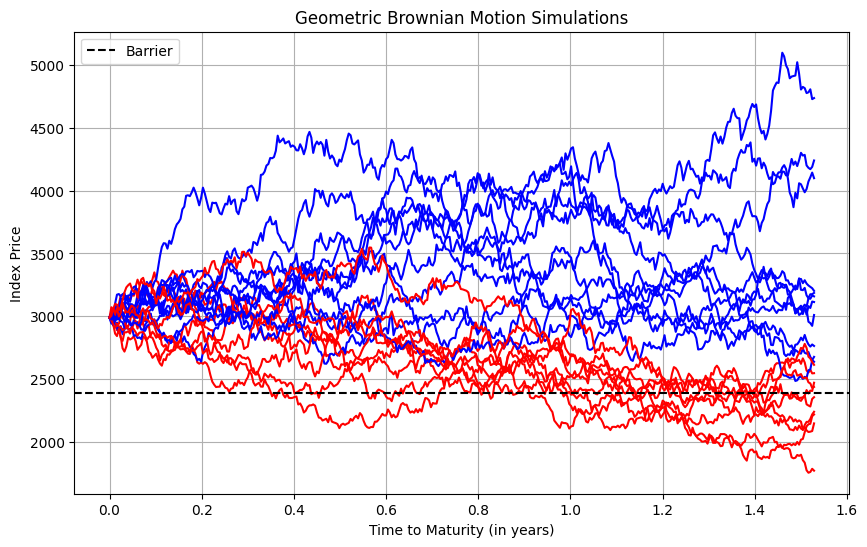

In [8]:
# Plot of the first 20 paths
time = np.linspace(0, T, n_steps)

plt.figure(figsize=(10, 6))

for i in range(min(20, n_simulations)):
    path = simulations[i]

    # Barrier condition
    if any(path < H):
        color = 'Red'
    else:
        color = 'Blue'

    plt.plot(time, path, color=color)

# Add barrier line
plt.axhline(y=H, color='black', linestyle='--', label='Barrier')

plt.title('Geometric Brownian Motion Simulations')
plt.xlabel('Time to Maturity (in years)')
plt.ylabel('Index Price')
plt.legend()
plt.grid(True)
plt.show()


Lastly, we price the las compontent of the replcating strateg, which is a vanilla put option, using the BS model.

In [9]:
# Pricing a Vanilla Put Option using B&S model
def BS_put(S0, K_1, T, mu, sigma):
    d1 = (np.log(S0 / K_1) + (mu + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K_1 * np.exp(-mu * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return put_price


put_price = BS_put(S0, K_1, T, r, sigma)*N #0.19 is Will's value for sigma, let's check this
print(f"The Price of the Vanilla Put Option is : {put_price:.4f}")

The Price of the Vanilla Put Option is : 140.5146


Consequently, we can now price the certificate by summing the prices of the three components identified in the replicating strategy.

In [10]:
def certificate():
  return (-put_price + option_price + zcb_price)

certificate_price = certificate()

print(f"Estimated price of the certificate: {certificate_price:.2f}")

Estimated price of the certificate: 954.11


**Total pricing function:**

In [11]:
def combined_price(S0,sigma,r,T):
  put_option = BS_put(S0, K_1, T, r, sigma)*N
  zcb_price = zcb(T,r,cap)
  down_and_out_option = down_and_out_barrier_option(S0, K_2, H, T, r,sigma,n_simulations,n_steps)*N
  return (zcb_price + down_and_out_option - put_option)


price_cert = combined_price(S0,sigma,r,T)

print(f"Estimated price of the certificate: {price_cert:.4f}")

Estimated price of the certificate: 953.8826


**Sesitivity Analysis: Determining the Greeks**


In [12]:
# Compute a fucntion for each greek for ease of computation

# Delta
def delta(combined_price, S, sigma, r, t, h=0.01):
    delta = (combined_price(S*1.01, sigma, r, t) - combined_price(S*0.99, sigma, r, t)) / (2* S*0.01)
    return delta

# Gamma
def gamma(combined_price, S, sigma, r, t, h=0.01):
    gamma = (combined_price(S*1.01, sigma, r, t) - 2 * combined_price(S, sigma, r, t) + combined_price(S*0.99, sigma, r, t)) / ((S*0.01) ** 2)
    return gamma

# Vega
def vega(combined_price, S, sigma, r, t, h=0.01):
    vega = (combined_price(S, sigma*1.01, r, t) -combined_price(S, sigma*0.99, r, t)) / (2 * S*0.01)
    return vega

# Theta
def theta(combined_price, S, sigma, r, t, h=0.01):
    theta = (combined_price(S, sigma, r, t) - combined_price(S, sigma, r, t *0.99)) / ( S*0.01)  #backward difference
    return theta

# Rho
def rho(combined_price, S, sigma, r, t, h=0.01):
    rho = (combined_price(S, sigma, r*1.01, t) - combined_price(S, sigma, r*0.99, t)) / (2 * S*0.01)
    return rho

# Compute Greeks
delta = delta(combined_price, S0, sigma, r, T)
gamma = gamma(combined_price, S0, sigma, r, T)
vega = vega(combined_price, S0, sigma, r, T)
theta = theta(combined_price, S0, sigma, r, T)
rho = rho(combined_price, S0, sigma, r, T)

print(f"Delta: {delta}")
print(f"Gamma: {gamma}")
print(f"Vega: {vega}")
print(f"Theta: {theta}")
print(f"Rho: {rho}")

Delta: 0.18590580524081515
Gamma: 0.0023147331260083984
Vega: -0.04446499105892796
Theta: -0.009694552065858657
Rho: -0.015513457691244308


Payoff Graph of the Product

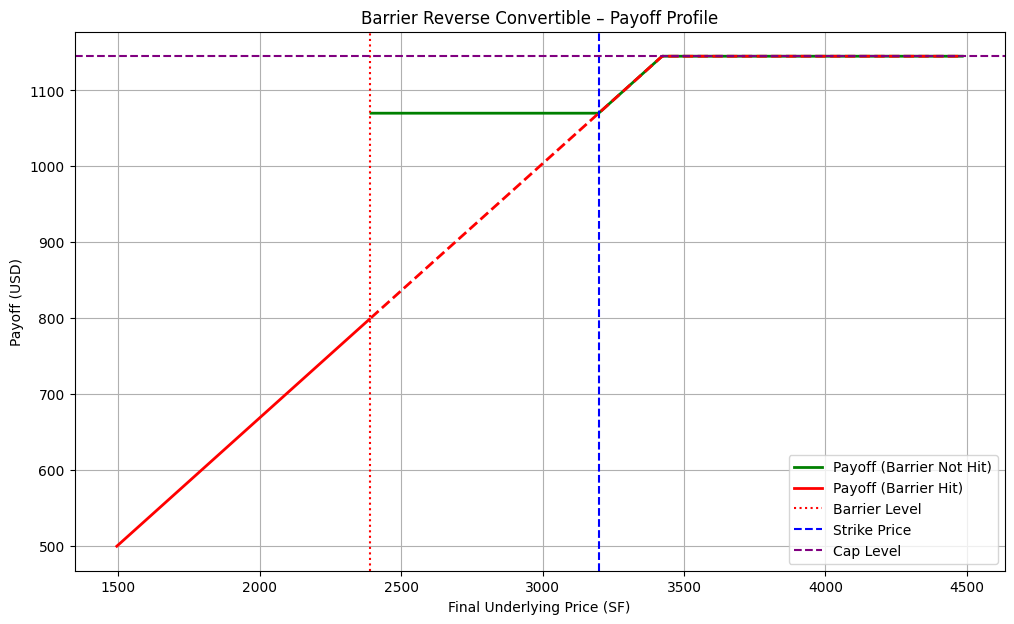

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
spot_reference = 2989.16
strike = 3198.40
cap = 3422.5882
barrier = 2391.33
R = 0.33454  # Quantity of underlyings

# Price range
SF = np.linspace(0.5 * spot_reference, 1.5 * spot_reference, 500)

# Indices for segments
SF_pre_barrier = SF[SF <= barrier]
# Changed this line to extend the dashed red line all the way to the end of SF
SF_barrier_to_end = SF[SF > barrier]

# Payoff if barrier IS hit (short put exposure, capped)
payoff_barrier_pre = np.minimum(cap, SF_pre_barrier) * R
# Changed this line to apply the payoff calculation to the extended segment
payoff_barrier_post_barrier = np.minimum(cap, SF_barrier_to_end) * R

# Payoff if barrier is NOT hit
SF_valid = SF[SF > barrier]  # Only show green line after barrier
payoff_no_barrier = np.minimum(cap, SF_valid + np.maximum(0, strike - SF_valid)) * R

# Plot
plt.figure(figsize=(12, 7))

# Barrier not hit payoff (green) — only after barrier
plt.plot(SF_valid, payoff_no_barrier, label='Payoff (Barrier Not Hit)', color='green', linewidth=2)

# Barrier hit payoff (red solid before barrier, dashed after)
plt.plot(SF_pre_barrier, payoff_barrier_pre, color='red', linewidth=2, label='Payoff (Barrier Hit)')
# Changed this line to plot the extended dashed red line
plt.plot(SF_barrier_to_end, payoff_barrier_post_barrier, color='red', linestyle='--', linewidth=2)


# Reference lines
plt.axvline(x=barrier, color='red', linestyle=':', label='Barrier Level')
plt.axvline(x=strike, color='blue', linestyle='--', label='Strike Price')
plt.axhline(y=cap * R, color='purple', linestyle='--', label='Cap Level')

# Labels and title
plt.title("Barrier Reverse Convertible – Payoff Profile")
plt.xlabel("Final Underlying Price (SF)")
plt.ylabel("Payoff (USD)")
plt.legend()
plt.grid(True)
plt.show()